## C S 329E HW7

# Ensemble Methods and Skewed Data

## Group 51: Medhavie Agnihotri and Jenny Fotso

For this week's homework we are going explore two ensemble methods:

  - AdaBoost, and
  - Random Forests
  
Along with applying different KPIs (key performance indicators) that are more appropriate to highly skewed data sets. 

The dataset contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 237 frauds out of 142,167 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.17% of all transactions.

It contains only numerical input variables which are the result of a [PCA transformation](https://en.wikipedia.org/wiki/Principal_component_analysis). Unfortunately, due to confidentiality issues, they cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount in Euros. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

At the end of this homework, I expect you to understand how to train and use ensemble classifiers, how to characterize model performance with ROC curves, and be familiar with the difference between accuracy, true positive rate, and positive predictive value. 

In [7]:
# These are the libraries you will use for this assignment, you may not import anything else
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_roc_curve

# This is the credit card data provided, we'll use sklearn methods to do cross validation
# to estimate error
df_cc = pd.read_csv('https://www.cs.utexas.edu/~chaney/cc.csv')

## Q1 Parition the data for cross validation

Load the data, and split the data set into $X$ (the feature dataframe, `df_X`) and $y$ (the target series `s_y`). Define our partitions.  

We know this is a _super_ skewed data set, so we worry about our target class being underrepresented in a random k-fold selection. With this in mind, we use a [stratifed k-fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html), since it will preserve our class balance in our experiements. Use $k=3$, . Instantiate an instance of the `StratifiedKFold` class, and use the generator `split` to populate the following dictonaries:
   - `d_train_df_X` : where the key is the fold number, and the value is the attribute training dataframe at that fold
   - `d_test_df_X`  : where the key is the fold number, and the value is the attribute test dataframe at that fold
   - `d_train_s_y`  : where the key is the fold number, and the value is the target training series at that fold
   - `d_train_s_y`  : where the key is the fold number, and the value is the target test series at that fold

In [22]:
df_X = df_cc.drop(columns=['Class'])
s_y = df_cc['Class']

In [23]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=23)

for train_index, test_index in skf.split(df_X, s_y):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [     2      3      4 ... 142400 142402 142403] TEST: [     0      1      8 ... 142397 142399 142401]
TRAIN: [     0      1      2 ... 142401 142402 142403] TEST: [     5      6      7 ... 142389 142398 142400]
TRAIN: [     0      1      5 ... 142399 142400 142401] TEST: [     2      3      4 ... 142396 142402 142403]


In [24]:
d_train_df_X = dict()
d_test_df_X = dict()
d_train_s_y = dict()
d_test_s_y = dict()

In [25]:
folds = skf.split(df_X, s_y)
count = 0;

# Assign values to each fold in the dictionaries
for train_index, test_index in folds:
    d_train_df_X[count] = df_X.iloc[train_index]
    d_test_df_X[count] = df_X.iloc[test_index]
    d_train_s_y[count] = s_y.iloc[train_index]
    d_test_s_y[count] = s_y.iloc[test_index]
    count += 1

In [26]:
# Look at the test data and verify that the target training is equally distributed as possible
for key in d_test_s_y.keys():
    print("Fold #" + str(key))
    print(d_test_s_y[key].value_counts())
    print()

Fold #0
0    47389
1       79
Name: Class, dtype: int64

Fold #1
0    47389
1       79
Name: Class, dtype: int64

Fold #2
0    47389
1       79
Name: Class, dtype: int64



## Section 1 - AdaBoost

# Q2 Test the Performance of AdaBoost

When we talked about AdaBoost in class, we used a collection of "Decision Stumps". In this assignment, we will use the implementation of [AdaBoost in Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html).  As you browse the documentation, you will notice that the default base esimator in this implentation is a `DecisionTreeClassifier(max_depth=1)` (our friend the decision stump). 

After you fit an AdaBoost model, you can call the method `predict` to get a class prediction, or you can call `predict_proba` to get the probability of being in the class `0` or the class `1`. These probabilities are used when creating ROC curves. 

Loop over the $k$ folds using the dictionaries from the first problem, and for each fold calculate the accuracy, TPR, the PPV, and the FPR (feel free to create helper functions to calcuate these metrics - do not use a library function to compute these metrics).  Plot the ROC curve for each fold. You may use the [plot roc curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html) from Scikit-learn.  There is a great example in the documentation [on plotting ROC curves in cross validation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html) that is helpful.  

When creating your AdaBoost classifier, please use the following parameters: 
`AdaBoostClassifier(n_estimators=25, random_state=23)`

Save the predictions from the 3rd fold into a variable called `y_hat_ab` for use in a future problem.


In [12]:
def calcAccuracy(ytrue, ypred):
  count = 0 
  index = 0
  totallen = len(ypred)
  for val in ytrue:
    if val == ypred[index]:
      count = count + 1
    index = index + 1
  return count/totallen

In [13]:
def calcTpr(ytrue, ypred):
  tp = 0
  fn = 0
  index = 0 
  for val in ytrue:
    if val == 1 and val == ypred[index]:
      tp = tp + 1
    if ypred[index] == 0 and val == 1:
      fn = fn + 1
    index = index + 1

  return tp/(tp+fn)

In [14]:
def calcPpv(ytrue, ypred):
  tp = 0
  fp = 0
  index = 0 
  for val in ytrue:
    if val == 1 and val == ypred[index]:
      tp = tp + 1
    if ypred[index] == 1 and val == 0:
      fp = fp + 1
    index = index + 1

  return tp/(tp+fp)

In [15]:
def calcFpr(ytrue, ypred):
  tn = 0
  fn = 0
  index = 0 
  for val in ytrue:
    if val == 0 and val == ypred[index]:
      tn = tn + 1
    if ypred[index] == 0 and val == 1:
      fn = fn + 1
    index = index + 1

  return tn/(tn+fn)

In [16]:
k = 3
acc_ab = np.zeros(k)
tpr_ab = np.zeros(k)
ppv_ab = np.zeros(k)
fpr_ab = np.zeros(k)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


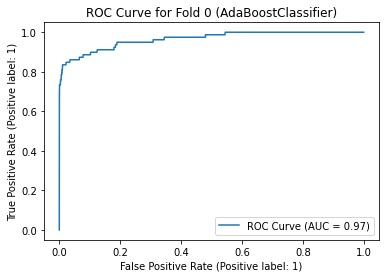

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


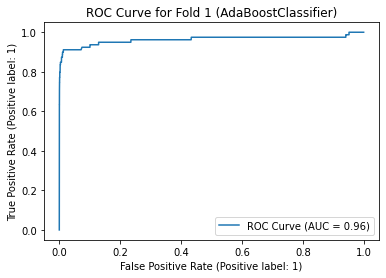

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


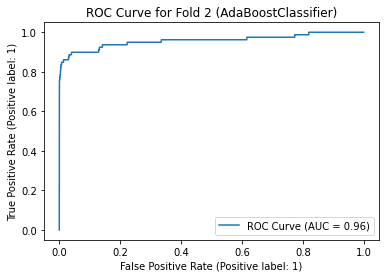

In [27]:
# Iterate through each fold
for key in d_test_s_y.keys(): 
    # Create AdaBoost Classifier
    abc = AdaBoostClassifier(n_estimators=25, random_state=23)
    
    # Pull training and test data from dictionaries
    train_X = d_train_df_X[key]
    test_X = d_test_df_X[key]
    train_y = d_train_s_y[key]
    test_y = d_test_s_y[key]
    
    # Fit the model and use it to predict values
    abc.fit(train_X, train_y)
    predict_y = abc.predict(test_X)
    
    if (key == 2):
        y_hat_ab = predict_y
        
    # Calculate performance of model
    ACC = 0;
    TP = 0;
    FN = 0;
    FP = 0;
    TN = 0;
    for i in range(len(predict_y)):
        if predict_y[i] == 1:
            if test_y.iloc[i] == 1:
                TP += 1
                ACC += 1
            else:
                FP += 1
        else:
            if test_y.iloc[i] == 0:
                TN += 1
                ACC += 1
            else:
                FN += 1
    acc_ab[key] = ACC/(TP+FP+TN+FN)
    tpr_ab[key] = TP/(TP+FN)
    ppv_ab[key] = TP/(TP+FP)
    fpr_ab[key] = FP/(FP+TN)
    
    # Plot ROC curves
    plot_roc_curve(abc, test_X, test_y, name="ROC Curve")
    plt.title("ROC Curve for Fold " + str(key) + " (AdaBoostClassifier)")
    plt.show()

In [28]:
print('The min, mean, and max TPR are: {:.2f}, {:.2f}, and {:.2f}'.format(tpr_ab.min(), tpr_ab.mean(), tpr_ab.max()))
print('The min, mean, and max PPV are: {:.2f}, {:.2f}, and {:.2f}'.format(ppv_ab.min(), ppv_ab.mean(), ppv_ab.max()))
print('The min, mean, and max ACC are: {:.2f}, {:.2f}, and {:.2f}'.format(acc_ab.min(), acc_ab.mean(), acc_ab.max()))

The min, mean, and max TPR are: 0.62, 0.65, and 0.71
The min, mean, and max PPV are: 0.75, 0.79, and 0.82
The min, mean, and max ACC are: 1.00, 1.00, and 1.00


## Q3 Test the Performance of Random Forests

Now, let's try another ensemble method: Random Forests, again using the [Scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). 

Following our book, we will build complete trees, with no pruning.  That means every leaf in the tree will be completelely pure, and if you exam an individual Decision Tree it would be overtrained to our training set.  While building the decision trees, at every internal node, we select $p$ attributes at random, and then find the best split that minimizes impurtity.  The value, $p$, is a hyperparamter of the Random Forest and corresponds to the `max_features` parameter in the Random Forest Class. 

After you fit an RandomForest model, you can call the method `predict` to get a class prediction, or you can call `predict_proba` to get the probability of being in the class `0` or the class `1`. These probabilities are used when creating ROC curves. 

Loop over the $k$ folds using the dictionaries from the first problem, and for each fold calculate the accuracy, TPR, the PPV, and the FPR (feel free to reuse the functions that you already wrote to calculate these values - do not use a library function to compute these metrics).  Plot the ROC curve for each fold. You may use the [plot roc curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html) from Scikit-learn. There is a great example in the documentation [on plotting ROC curves in cross validation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html) that is helpful.  

When creating your Random Forest classifier, please use the following parameters: 
`RandomForestClassifier(criterion="entropy", max_features="sqrt", random_state=23)`

Save the predictions from the 3rd fold into a variable called `y_hat_rf` for use in a future problem.

In [29]:
k = 3
acc_rf = np.zeros(k)
tpr_rf = np.zeros(k)
ppv_rf = np.zeros(k)
fpr_rf = np.zeros(k)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


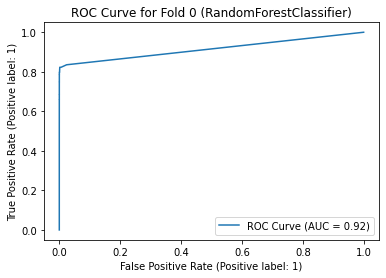

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


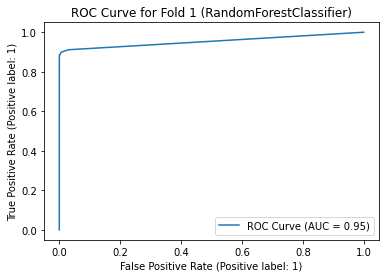

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


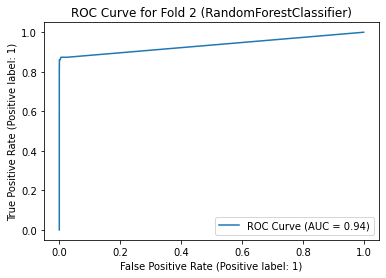

In [30]:
# Iterate through each fold
for key in d_test_s_y.keys(): 
    # Create Random Forest Classifier
    rfc = RandomForestClassifier(criterion="entropy", max_features="sqrt", random_state=23)
    
    # Pull training and test data from dictionaries
    train_X = d_train_df_X[key]
    test_X = d_test_df_X[key]
    train_y = d_train_s_y[key]
    test_y = d_test_s_y[key]
    
    # Fit the model and use it to predict values
    rfc.fit(train_X, train_y)
    predict_y = rfc.predict(test_X)
    
    if (key == 2):
        y_hat_rf = predict_y
        
    # Calculate performance of model
    ACC = 0;
    TP = 0;
    FN = 0;
    FP = 0;
    TN = 0;
    for i in range(len(predict_y)):
        if predict_y[i] == 1:
            if test_y.iloc[i] == 1:
                TP += 1
                ACC += 1
            else:
                FP += 1
        else:
            if test_y.iloc[i] == 0:
                TN += 1
                ACC += 1
            else:
                FN += 1
    acc_rf[key] = ACC/(TP+FP+TN+FN)
    tpr_rf[key] = TP/(TP+FN)
    ppv_rf[key] = TP/(TP+FP)
    fpr_rf[key] = FP/(FP+TN)
    
    # Plot ROC curves
    plot_roc_curve(rfc, test_X, test_y, name="ROC Curve")
    plt.title("ROC Curve for Fold " + str(key) + " (RandomForestClassifier)")
    plt.show()

In [31]:
print('The min, mean, and max TPR are: {:.2f}, {:.2f}, and {:.2f}'.format(tpr_rf.min(), tpr_rf.mean(), tpr_rf.max()))
print('The min, mean, and max PPV are: {:.2f}, {:.2f}, and {:.2f}'.format(ppv_rf.min(), ppv_rf.mean(), ppv_rf.max()))
print('The min, mean, and max ACC are: {:.2f}, {:.2f}, and {:.2f}'.format(acc_rf.min(), acc_rf.mean(), acc_rf.max()))

The min, mean, and max TPR are: 0.75, 0.78, and 0.80
The min, mean, and max PPV are: 0.92, 0.93, and 0.95
The min, mean, and max ACC are: 1.00, 1.00, and 1.00


# Q4 Calculate the Cost of Fraud 

In the above problems, we saved the predictions of the 3rd fold into the variables `y_hat_ab` and `y_hat_rf` for the AdaBoost and RandomForest models respectively. 

Now, Mr. Bank Man wants you to tell him how much money he is going to save if he deploys either of these fraud algorithms to the real-time payment processing system.  Assume that there is not a currently deployed fraud detection algorithm.  

For every fraudulent transaction that is not predicted as fraudulent the bank looses twice the value of the transaction.  So, if a fradulent charge for €10 is undectected, it costs the bank €20.  Also, if a charge is predicted as fradulent, but wasn't, it costs the bank a flat fee of €3 in customer service support to communicate with the customer, and mark the possible fraud as a normal transaction. 

Using the 3rd fold test sample, calculate how much money Mr Bank Man will save by deploying each algorithm, and make a recommendation of which algorithm to deploy to production.  To calculate savings to the bank, you must first calculate the cost of the status quo, which is having no algorithm deployed. 

In [32]:
test_X = d_test_df_X[2]
test_y = d_test_s_y[2]

# Find number of original fraudulent transactions
num_fraud = test_y.value_counts()[1]
print("Original Cost of Fraudulent Transactions: $" + str(num_fraud * 20))

# Find number of discovered fraudulent transactions
cost_ab = 0
cost_rf = 0
for i in range(len(test_y)):
    if (test_y.iloc[i] == 1):
        if (y_hat_ab[i] == 0):
            cost_ab += 20
        if (y_hat_rf[i] == 0):
            cost_rf += 20
    if (y_hat_ab[i] == 1 and test_y.iloc[i] == 0):
        cost_ab += 3
    if (y_hat_rf[i] == 1 and test_y.iloc[i] == 0):
        cost_rf += 3
        
print("Cost after Applying AdaBoost Classifier: $" + str(cost_ab))
print("Cost after Applying Random Forest Classifier: $" + str(cost_rf))

Original Cost of Fraudulent Transactions: $1580
Cost after Applying AdaBoost Classifier: $502
Cost after Applying Random Forest Classifier: $349


➡️ YOUR ANSWER HERE Mr Bank man will \[save|lose\] money, if we deploy the ___ algorithm! YOUR ANSWER HERE ⬅️

In [33]:
print("The bank will save $" + str(num_fraud * 20 - cost_ab) + " if we deploy the AdaBoost algorithm!")
print("The bank will save $" + str(num_fraud * 20 - cost_rf) + " if we deploy the Random Forest algorithm!")

The bank will save $1078 if we deploy the AdaBoost algorithm!
The bank will save $1231 if we deploy the Random Forest algorithm!
